<a href="https://colab.research.google.com/github/alexfc14/fancy-neural-networks/blob/master/mask_vs_not_gradcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Building an Interpretable Face Mask Classifier
no_dataset, 
small_data, 
few_shot_learning, 
knowledge_transfer, 
interpretability

## Get some Data

Since we don't own a dataset on mask vs no mask images and want to make things reproducible, we will make use of the patched google image scraper
[google_images_download](https://github.com/Joeclinton1/google-images-download.git), a package for downloading up to 100 images from google search results.

In [ ]:
# !pip install google_images_download
!pip install git+https://github.com/Joeclinton1/google-images-download.git

In [ ]:
from google_images_download import google_images_download

response = google_images_download.googleimagesdownload()

paths = response.download({
    'keywords':'person, wearing mask',
    "print_urls":False,
    'output_directory':'images/'})

In [7]:
#!rm -r images
!ls images

 person  ' wearing mask'


In [8]:
#generics
import pandas as pd
from matplotlib import pyplot as plt

#read-preproc
from keras.preprocessing.image import ImageDataGenerator

#models
from keras import models, losses, metrics
from keras.models import Sequential, Model
from keras.layers import Dense,Dropout, Flatten, Conv2D, MaxPooling2D

#eval
from sklearn.metrics import classification_report, confusion_matrix

Using TensorFlow backend.



We'll make use of keras.preprocessing.image.ImageDataGenerator
    
This module allows to load an image classification dataset iteratively from disk, provided a folder tree with images inside each class folder, like the one we just downloaded.

- This saves us the hustle while reading of manually:
 * resizing to 224x224 x3 (we keep the color)
 * rescaling to 0-1 values instead of 0-255
 * specifying channel order RGB vs BGR (opencv) vs grayscale
 * fixing redundant array shapes: (w, h) vs (w, h, 1) vs (w, h, 3)
 * Shuffling samples
 * Splitting into subsets
   * training
   * validation
    
- Avoids loading the whole dataset into RAM, but just iterate x,y pairs.
    
- Data Augmentation, from array (flow method) or from disk (flow_from_directory method). We set it to generate  random transformations in:
     * point of view:
        - zoom: 0.1
        - rotation: 20 deg
        - height shift: 0.1 (small not to miss the helmet)
        - width shift: 0.1
        - shear: 0.1
        - horizontal flip
     * illumination:
        - brightness: 0.3-1.0

In [9]:
target_size = 224
channels = 3
batch_size = 8

datagen = ImageDataGenerator(rotation_range=15, 
                             width_shift_range=0.1, height_shift_range=-0.1,
                             shear_range=0.1, zoom_range=0.1,
                             horizontal_flip=True,
                             fill_mode="constant",
                             rescale=1./255,
                             brightness_range=(0.35,1),
                             validation_split=0.10
                            )

train_generator = datagen.flow_from_directory(
    'images',
    target_size=(target_size, target_size),
    batch_size=batch_size,
    # class_mode='binary',
    color_mode="grayscale" if channels == 1 else 'rgb',
    interpolation="bicubic",
    shuffle=True,
    subset='training'
)

valid_generator = datagen.flow_from_directory(
    'images',
    target_size=(target_size, target_size),
    batch_size=batch_size,
    # class_mode='binary',
    color_mode="grayscale" if channels == 1 else 'rgb',
    interpolation="bicubic",
    shuffle=True,
    subset='validation'
)

train_step_size = train_generator.n//train_generator.batch_size
valid_step_size = valid_generator.n//valid_generator.batch_size

Found 170 images belonging to 2 classes.
Found 18 images belonging to 2 classes.


Check how our data looks

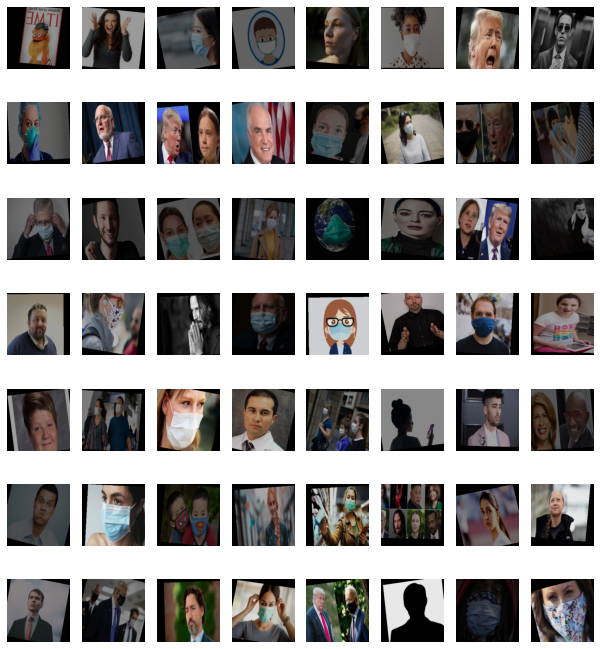

In [35]:
#ImageDataGenerator generates indefinitely. Stop it after a desired number.
from itertools import islice as first

def generator_display(gen, batches=7):
    fig, ax = plt.subplots(nrows=batches, ncols=batch_size, figsize=(1.5*batches,1.5*gen.batch_size))
    
    for row in ax:
        for col in row:
            col.axis('off')
    for i, (x_batch, y_batch) in enumerate(first(gen,batches)):
        for j,(x,y) in enumerate(zip(x_batch,y_batch)):
            ax[i,j].imshow(x)
    
    plt.show()

generator_display(train_generator)

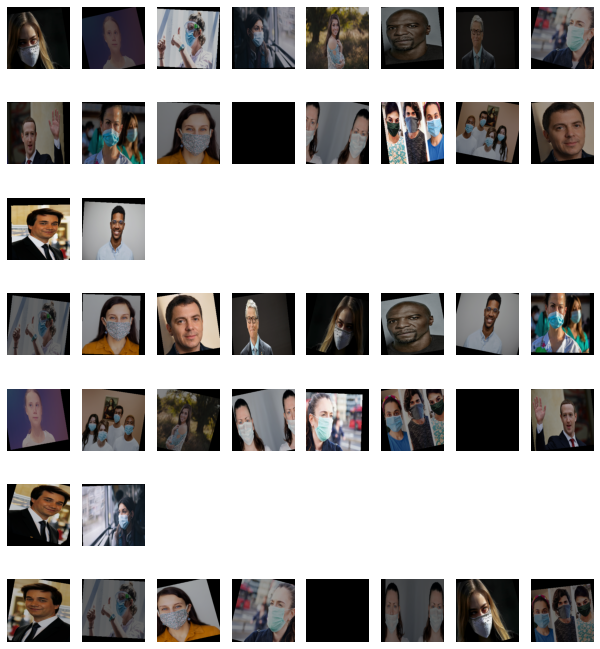

In [38]:
generator_display(valid_generator,batches=7)

### VGG16 transfer learning

While we coud design manually the architecture, keras offers top performing models like the VGG16, with a very fine tuned architecture and weights resulting from training it to classify on the large *imagenet* dataset.

Even if it was originally trained for classifying objects among a large variety of classes different than ours, the feature space resulting from the convolutional layers output is extremely rich, so we build some dense layers on top of it and only train the dense layers weights on our dataset.

In [13]:
from keras.applications import VGG16
from keras.models import Sequential, load_model, Model
from keras.optimizers import Adam

# def VGG_binary(input_shape, classes):
def VGG_categorical(input_shape, classes):
    # Initialize VGG16 using pre-trained weights on imagenet and use transfer learning for re-training the last layers
    model = VGG16(weights='imagenet', include_top=False,input_shape=input_shape)
    # Freeze all the layers except for the last ones, so that we can retrain the last ones.
    for layer in model.layers[:-4]:
        layer.trainable = False
    # Adding our new layers    
    top_layers = model.output
    top_layers = Flatten(input_shape=model.output_shape[1:])(top_layers)
    top_layers = Dense(500, kernel_initializer='random_uniform', activation="relu")(top_layers)
    top_layers = Dropout(0.4)(top_layers)
    top_layers = Dense(50, kernel_initializer='random_uniform', activation="relu")(top_layers)
    top_layers = Dropout(0.3)(top_layers)
    top_layers = Dense(classes, activation="softmax")(top_layers)
    # top_layers = Dense(1, activation="sigmoid")(top_layers)
    
    # Add top layers on top of freezed (not re-trained) layers of VGG16
    model = Model(input = model.input, output = top_layers)
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['binary_accuracy'])
    
    return model

model = VGG_categorical((target_size,target_size,channels),classes=2)
model.summary()

58892288/58889256 [==============================] - 2s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


## Train

In [14]:
model.fit_generator(train_generator,	
                    epochs=15,
                    verbose=1,
                    steps_per_epoch= train_step_size,
                    validation_data=valid_generator,
                    validation_steps=valid_step_size,
                   )

Epoch 1/15
21/21 [==============================] - 17s 788ms/step - loss: 0.9315 - binary_accuracy: 0.6111 - val_loss: 0.6598 - val_binary_accuracy: 0.6250
Epoch 2/15
21/21 [==============================] - 12s 563ms/step - loss: 0.5802 - binary_accuracy: 0.7160 - val_loss: 0.7105 - val_binary_accuracy: 0.6000
Epoch 3/15
21/21 [==============================] - 10s 465ms/step - loss: 0.4652 - binary_accuracy: 0.7963 - val_loss: 0.5328 - val_binary_accuracy: 0.8000
Epoch 4/15
21/21 [==============================] - 12s 590ms/step - loss: 0.3531 - binary_accuracy: 0.8704 - val_loss: 0.4256 - val_binary_accuracy: 0.8750
Epoch 5/15
21/21 [==============================] - 10s 457ms/step - loss: 0.3699 - binary_accuracy: 0.8333 - val_loss: 0.2088 - val_binary_accuracy: 0.9000
Epoch 6/15
21/21 [==============================] - 12s 587ms/step - loss: 0.2144 - binary_accuracy: 0.9198 - val_loss: 0.6584 - val_binary_accuracy: 0.8000
Epoch 7/15
21/21 [==============================] - 11s 52

KeyboardInterrupt: ignored

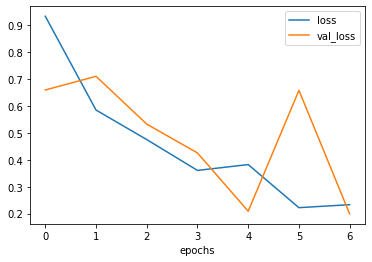

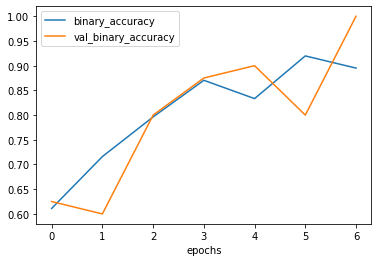

In [15]:
def plot_learning_curve(model):
    """Display loss and metrics at each epoch of a keras model"""
    hist=pd.DataFrame(model.history.history)
    hist=hist.reset_index().rename({'index':'epochs'},axis='columns').set_index('epochs')
    for loss in model.metrics_names:
        hist[[loss,'val_'+loss]].plot();plt.show()

plot_learning_curve(model)

## Evaluate the model

In [18]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.utils.multiclass import unique_labels
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    classes = classes[unique_labels(y_true, y_pred).astype(int)]
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes)
    disp = disp.plot(include_values=True,cmap=plt.cm.Blues)
    plt.show()
    
    tn, fp, fn, tp = cm.ravel()
    summary = pd.Series({'acc':(tn+tp)/(tn+tp+fn+fp), 'precision':(tp)/(tp+fp),'recall':(tp)/(tp+fn)})
    display(summary.to_frame('Summary').round(2))

Check for validation errors

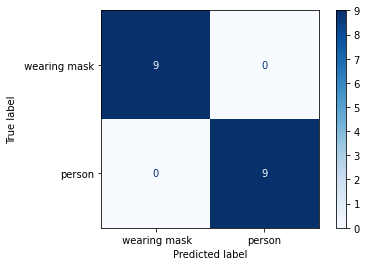

,Summary
acc,1.0
precision,1.0
recall,1.0


In [19]:
valid_data = [(x,y) for batch_x,batch_y in first(valid_generator,3) for x,y in zip(batch_x,batch_y)]
X_valid = np.array([x for x,y in valid_data])
Y_valid = np.array([y for x,y in valid_data])
Y_pred_valid = model.predict(X_valid, verbose=1)
Y_pred_valid = np.argmax(Y_pred_valid, axis=1)
Y_valid = np.argmax(Y_valid, axis=1)

classes = np.array(list(valid_generator.class_indices.keys()))

plot_confusion_matrix(Y_valid, Y_pred_valid, classes=classes)

Where did it fail?

In [ ]:
for x,y,y_pred in zip(X_valid,Y_valid,Y_pred_valid):
    if y!=y_pred:
        print('real',classes[y],'pred',classes[y_pred])
        plt.imshow(x);plt.axis('off');plt.show()

Check for train errors

154/154 [==============================] - 1s 5ms/step


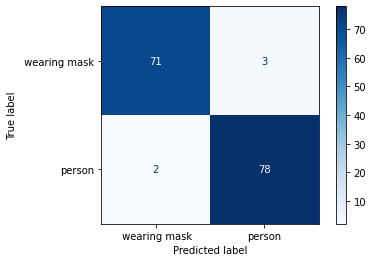

,Summary
acc,0.97
precision,0.96
recall,0.98


In [22]:
data_train = [(x,y) for batch_x,batch_y in first(train_generator,20) for x,y in zip(batch_x,batch_y)]
X_train = np.array([x for x,y in data_train])
Y_train = np.array([y for x,y in data_train])
Y_pred_train = model.predict(X_train, verbose=1)
# Y_pred_train = np.around(Y_pred_train)
Y_pred_train = np.argmax(Y_pred_train, axis=1)

Y_train = np.argmax(Y_train, axis=1)

classes = np.array(list(train_generator.class_indices.keys()))

plot_confusion_matrix(Y_train, Y_pred_train, classes=classes)

#Grad CAM

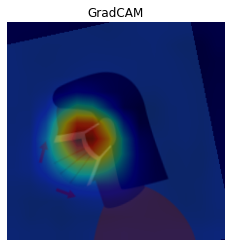

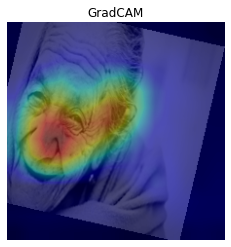

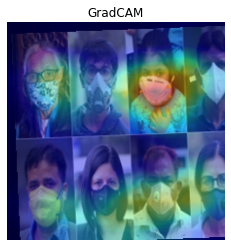

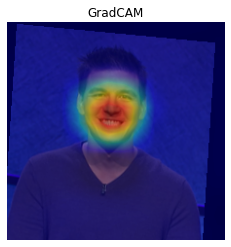

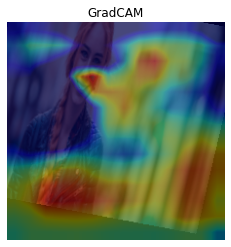

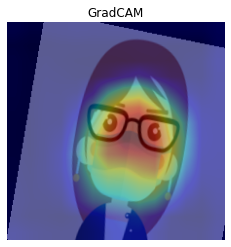

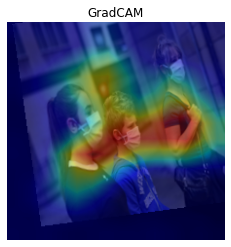

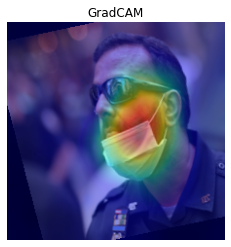

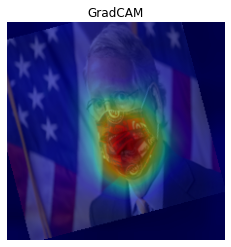

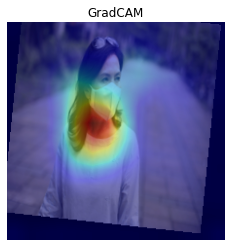

In [30]:
from keras import backend as K
import cv2

def grad_cam(input_model, image, cls, layer_name):
    """GradCAM method for visualizing input saliency."""
    class_score = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(class_score, conv_output)[0]
    # Normalize if necessary
    # grads = normalize(grads)
    gradient_function = K.function([input_model.input], [conv_output, grads])

    activations, grads_val = gradient_function([image])
    activations, grads_val = activations[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(activations, weights)

    #Upsize
    cam = cv2.resize(cam, (target_size, target_size), cv2.INTER_LINEAR)
    #Draw only positive contributions
    cam = np.maximum(cam, 0)
    #Normalize values
    cam = cam / cam.max()
    return cam

def show_blend(img, cam):
    plt.title('GradCAM')
    plt.axis('off')
    plt.imshow(img)
    plt.imshow(gradcam, cmap='jet', alpha=0.4)
    plt.show()

for x,y in zip(X_train[:10], Y_train[:10]):
  gradcam = grad_cam(model, np.array([x]), cls=y, layer_name='block5_conv3')
  show_blend(x, gradcam)

Errors in train

real  wearing mask pred person


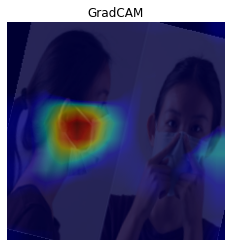

real  wearing mask pred person


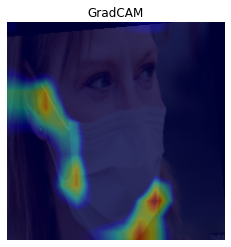

real  wearing mask pred person


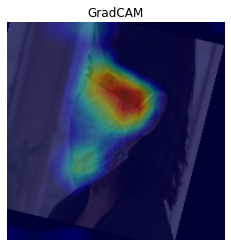

real person pred  wearing mask


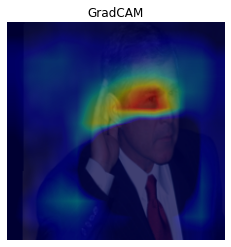

real person pred  wearing mask


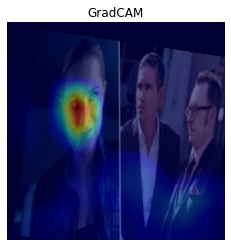

In [29]:
for x,y,y_pred in zip(X_train,Y_train,Y_pred_train):
    if y!=y_pred:
        print('real',classes[y],'pred',classes[y_pred])
        gradcam = grad_cam(model, np.array([x]), cls=y, layer_name='block5_conv3')
        show_blend(x, gradcam)